In [1]:
import pandas as pd
import numpy as np
from pydataset import data
import os
import env
import acquire as a
import prepare as p
import wrangle as w
import evaluate as e

#Stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind, chi2_contingency


#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#sklearn split, impute, math stuff
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Decision Tree, Random Forest, KNN
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")


## Questions
1. Is a home's value influenced by it's square feet?
2. Is a home's value influenced by the number of bedrooms it has?
3. Is a home's value influenced by the number of bathrooms it has?

# Acquire Zillow

In [2]:
# wrangle zillow
df = w.wrangle_zillow()
df.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips
0,2.0,1.0,1412.0,222671.0,6037.0
1,3.0,2.0,1296.0,64968.0,6037.0
2,3.0,1.0,1044.0,126800.0,6037.0


In [3]:
# deep copy to maintain integrity of original df for future use
df2 = df.copy()

In [4]:
# Dropping year. Not using as a driver, maybe use after MVP
# df.drop(['year'], axis=1, inplace=True)

In [5]:
# getting dummies for fips
#df = pd.get_dummies(df, columns=['fips'], drop_first=False)
#df.head(3)

In [6]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55725 entries, 0 to 56078
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   55725 non-null  float64
 1   bathrooms  55725 non-null  float64
 2   sq_ft      55725 non-null  float64
 3   tax_value  55725 non-null  float64
 4   fips       55725 non-null  float64
dtypes: float64(5)
memory usage: 2.6 MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,55725.0,3.304047,0.935885,0.0,3.0,3.0,4.0,25.0
bathrooms,55725.0,2.249376,0.997815,0.0,2.0,2.0,3.0,20.0
sq_ft,55725.0,1868.647214,966.632187,20.0,1261.0,1630.0,2216.0,26345.0
tax_value,55725.0,456282.496474,593476.458525,105.0,188268.0,330212.0,534083.0,30166843.0
fips,55725.0,6048.770875,21.148131,6037.0,6037.0,6037.0,6059.0,6111.0


# Explore

### Drop Outliers

In [8]:
df2.tax_value.quantile(.99)

2640524.7600000026

In [9]:
df2.sq_ft.quantile(.99)

5272.760000000002

In [10]:
df.shape

(55725, 5)

#### Square Feet

In [11]:
# 6349 square feet is the 98th percentile
# outliers above are well above this size. 
# Drop anything above 4472.0 square feet
df.sq_ft.quantile(.99)

5272.760000000002

In [12]:
# Drop anything above 5272 square feet. 
# 280 observations dropped
df = df[df['sq_ft'] < 5272]
df.shape

(55166, 5)

#### Tax Value

In [13]:
# Will drop anyting above $2146463
df.tax_value.quantile(.99)

2146463.099999996

In [14]:
# Dropping top 1% of most expensive houses 
#  observations dropped
df = df[df['tax_value'] < 2146463]
df.shape

(54614, 5)

#### Zero Bedrooms or Bathrooms

In [15]:
# Dropping any homes with no bedrooms
df = df[df['bedrooms'] >= 1]
df.shape

(54500, 5)

In [16]:
# Dropping any homes with no bathrooms
df = df[df['bathrooms'] >= 1]
df.shape

(54472, 5)

#### Bedrooms

In [17]:
# 99.5th percentile of bedrooms
df.bedrooms.quantile(.99)

6.0

In [18]:
# Dropping anything about 99.5th percentile for bedrooms
df = df[df['bedrooms'] <= 5]
df.shape

(53893, 5)

#### Bathrooms

In [19]:
# 99th percentile of bathrooms
df.bathrooms.quantile(.99)

5.0

In [20]:
# Dropping anything about 99th percentile for bathrooms
df = df[df['bathrooms'] <= 5]
df.shape

(53702, 5)

### Split Data and Correlation table

In [21]:
# Splitting data
train, val, test = p.split_data_continious(df)
train.shape, val.shape, test.shape

((30072, 5), (12889, 5), (10741, 5))

In [22]:
# correlations table 
train.corr()

,bedrooms,bathrooms,sq_ft,tax_value,fips
bedrooms,1.000000,0.602998,0.597176,0.249615,0.153513
bathrooms,0.602998,1.000000,0.811368,0.485461,0.118401
sq_ft,0.597176,0.811368,1.000000,0.569482,0.130888
tax_value,0.249615,0.485461,0.569482,1.000000,0.060896
fips,0.153513,0.118401,0.130888,0.060896,1.000000


<div class="alert alert-block alert-success">
<b>Correlation:<br>
Square Feet/ tax_value: 57.09% correlated<br>
Bedrooms / tax_value: 25.47% correlated<br>
Bathrooms / tax_value: 49.07% correlated<br>

In [23]:
# deep copy to maintain integrity of original train data for future use. scaling on copy
train_scaled = train.copy()

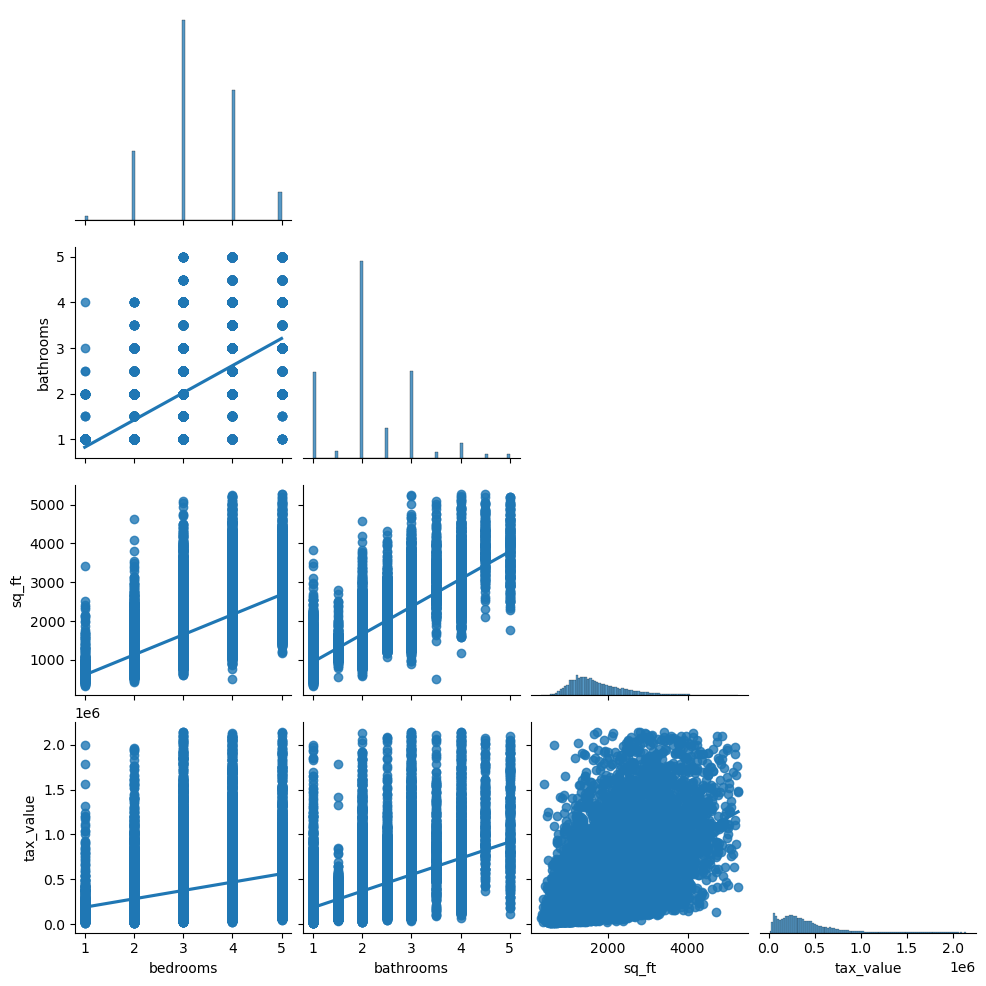

In [24]:
# Pairplot Kind='reg'
sns.pairplot(train[['bedrooms','bathrooms','sq_ft','tax_value']], kind='reg', corner=True)

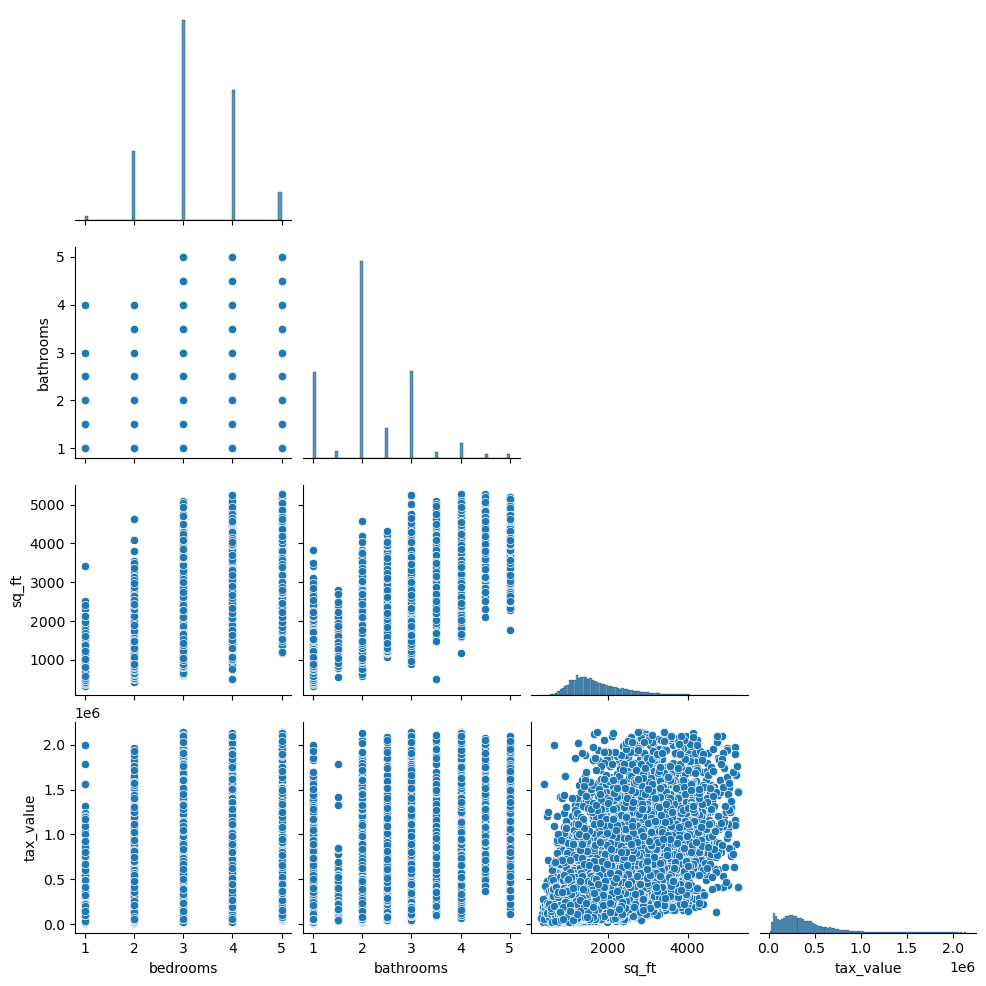

In [25]:
sns.pairplot(train[['bedrooms','bathrooms','sq_ft','tax_value']], corner=True)

##  Q1. Is a home's value influenced by it's square feet?

<AxesSubplot:xlabel='sq_ft', ylabel='tax_value'>

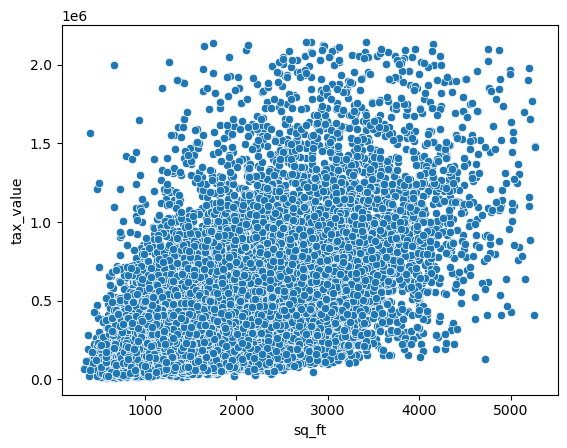

In [26]:
sns.scatterplot(x='sq_ft', y='tax_value', data=train)

<div class="alert alert-block alert-success">
<b>Takeaways:<br>
The highest density of houses appear to range from around 1000 - 4000 square feet with value from 100,000ish - 1.5mil, highest density<br>
-----------------------------<br>
    hue by FIPS after MVP




<AxesSubplot:xlabel='sq_ft', ylabel='tax_value'>

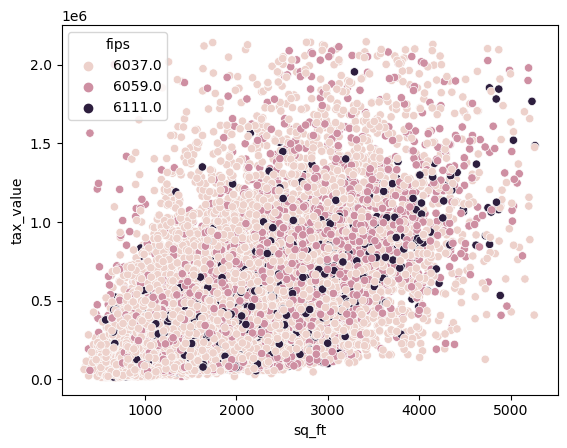

In [27]:
# For after MVP
sns.scatterplot(x='sq_ft', y='tax_value', hue='fips', data=train)

**Stats Test**

Continious / Continious

**H0: There is significant relation between a home's value and it's square footage.**

**Ha: There is a significant relation between a home's value and it's square footage.**

confidence interval: 95%

alpha = 0.05

In [28]:
stats.pearsonr(train.sq_ft, train.tax_value)

PearsonRResult(statistic=0.5694819323334069, pvalue=0.0)

In [29]:
train.quantile(.5)

bedrooms          3.0
bathrooms         2.0
sq_ft          1603.5
tax_value    321014.0
fips           6037.0
Name: 0.5, dtype: float64

<div class="alert alert-block alert-success">
<b>Takeaways:<br>
P-value is lower than 0.5, thus we reject the null hypotheses. <br>
There is a significant relation between square footage and the home's value.

## Q2. Is a home's value influenced by the number of bedrooms it has?

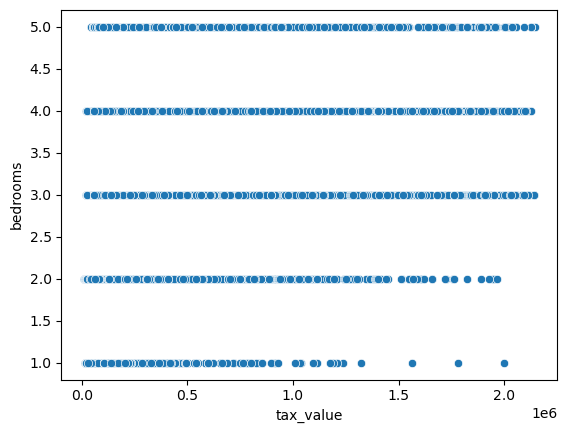

In [30]:
sns.scatterplot(x='tax_value', y='bedrooms', data=train)
plt.show()

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

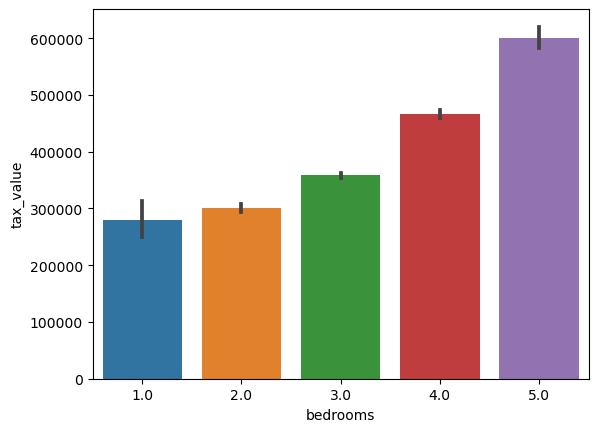

In [31]:
# Barplot of bedrooms vs tax_value
sns.barplot(x='bedrooms', y='tax_value', data=train)

<div class="alert alert-block alert-success">
<b>Takeaways:<br>
As number of bedrooms increase, the tax value increases.<br>


In [32]:
sample = train.sample(5000)

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

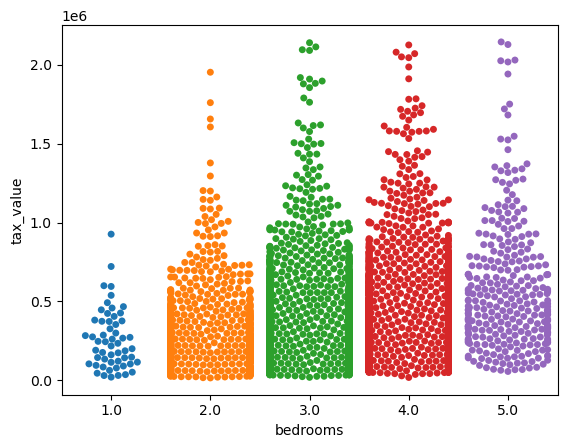

In [33]:
sns.swarmplot(x='bedrooms', y='tax_value', data=sample)

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

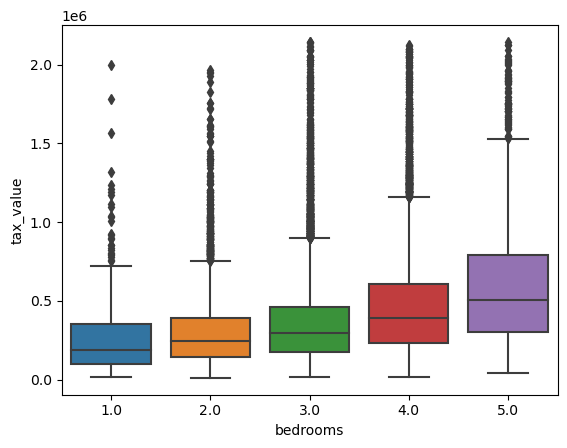

In [34]:
# Boxplot
sns.boxplot(x='bedrooms', y='tax_value', data=train)

In [35]:
# Value counts of bedrooms
df.bedrooms.value_counts()

3.0    24810
4.0    16160
2.0     8691
5.0     3471
1.0      570
Name: bedrooms, dtype: int64

<div class="alert alert-block alert-success">
<b>Takeaways:<br>
The median home value increases as the number of bedrooms increase.<br>
Of the train dataset, most homes have 3 bedrooms, followed by 4 bedrooms and so on.

### Stats Test

Discrete / Continious

**H0: There is significant relation between a home's value and it's number of bedrooms.**

**Ha: There is a significant relation between a home's value and it's number of bedrooms.**

confidence interval: 95%

alpha = 0.05

In [36]:
stats.ttest_ind(train['bedrooms'], train['tax_value'], equal_var=False)

Ttest_indResult(statistic=-219.44660265122454, pvalue=0.0)

<div class="alert alert-block alert-success">
<b>Results:<br>
P-value/2 is less than 0.05, thus we reject the null hypotheses.<br>
There is a significant relation between a home's value and it's number of bedrooms.

## Q3. Is a home's value influenced by the number of bathrooms it has?

<AxesSubplot:title={'center':' Bathrooms and Tax Value'}, xlabel='bathrooms', ylabel='tax_value'>

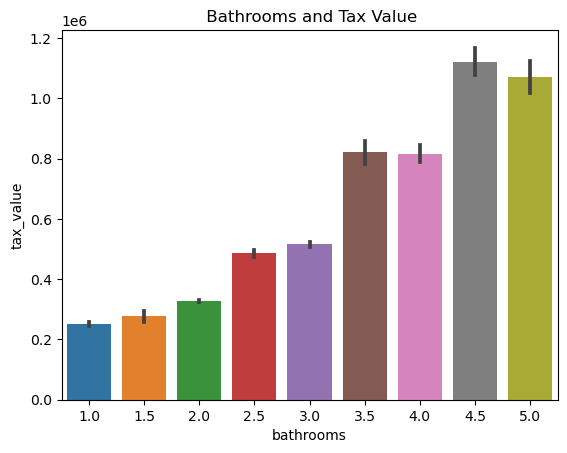

In [37]:
# Barplot of bathrooms and tax value.
plt.title(' Bathrooms and Tax Value')
sns.barplot(x='bathrooms', y='tax_value', data=train)

In [38]:
train.bathrooms.value_counts()

2.0    13667
3.0     6031
1.0     5926
2.5     2086
4.0     1035
1.5      434
3.5      384
5.0      277
4.5      232
Name: bathrooms, dtype: int64

<div class="alert alert-block alert-success">
<b>Results:<br>
As number of bathrooms increase, the average home's value increases.<br>
Interestingly, adding a half bath(powder room) drastically increases a home's value. Except for 4.5 to 5 bathrooms.


### Stats Test

Discrete / Continious

**H0: There is significant relation between a home's value and it's number of bedrooms.**

**Ha: There is a significant relation between a home's value and it's number of bedrooms.**

confidence interval: 95%

alpha = 0.05

In [109]:
# variables that will be used in stats test
xx = train[train['bedrooms'] <= 3]['bedrooms']
yy = train[train['bedrooms'] > 3]['bedrooms']

In [110]:
stats.ttest_ind(xx, yy, equal_var=False)

Ttest_indResult(statistic=-288.21631984559923, pvalue=0.0)

<div class="alert alert-block alert-success">
<b>Results:<br>
P-value/2 is less than 0.05, thus we reject the null hypotheses.<br>
There is a significant relation between a home's value and it's number of bathrooms.

## Is a home's value influenced by it's FIPS code?

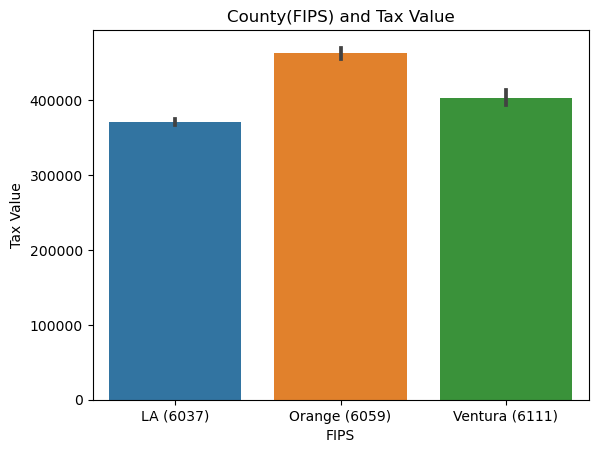

In [40]:
ax = sns.barplot(x='fips', y='tax_value', data=train)
ax.set_xticklabels(['LA (6037)','Orange (6059)','Ventura (6111)'])
plt.xlabel('FIPS')
plt.ylabel('Tax Value')
plt.title('County(FIPS) and Tax Value')
plt.show()

In [118]:
oc = train[train['fips'] == 6059]['tax_value']
overall = train['tax_value']

In [126]:
t,p = stats.ttest_1samp(oc, overall.mean())

In [127]:
t, p

(17.60733406928542, 5.0095029459878605e-68)

# Modeling

### Feature Engineering (dummies & scaling)

In [41]:
train.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips
11875,5.0,3.0,3128.0,1018390.0,6059.0
32390,3.0,2.0,1572.0,160053.0,6037.0
30688,4.0,3.5,3590.0,1154661.0,6059.0


In [42]:
# Train dummies
train_scaled = pd.get_dummies(train, columns=['fips'])
train_scaled.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0
11875,5.0,3.0,3128.0,1018390.0,0,1,0
32390,3.0,2.0,1572.0,160053.0,1,0,0
30688,4.0,3.5,3590.0,1154661.0,0,1,0


In [43]:
# Val dummies
val = pd.get_dummies(val, columns=['fips'])
val.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0
52444,4.0,2.0,1220.0,188564.0,1,0,0
40724,4.0,1.0,1377.0,489000.0,0,1,0
22651,2.0,1.0,792.0,65585.0,1,0,0


In [44]:
# test dummies
test = pd.get_dummies(test, columns=['fips'])
test.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0
38008,3.0,2.0,1421.0,282830.0,1,0,0
12727,5.0,4.0,2750.0,947619.0,1,0,0
19225,4.0,3.0,2822.0,464845.0,1,0,0


In [45]:
train

,bedrooms,bathrooms,sq_ft,tax_value,fips
11875,5.0,3.0,3128.0,1018390.0,6059.0
32390,3.0,2.0,1572.0,160053.0,6037.0
30688,4.0,3.5,3590.0,1154661.0,6059.0
5490,3.0,2.0,1648.0,286484.0,6037.0
27946,4.0,1.0,1416.0,197285.0,6037.0
...,...,...,...,...,...
36825,3.0,2.0,1390.0,390182.0,6037.0
23173,3.0,2.0,1446.0,229288.0,6037.0
46576,2.0,2.0,1476.0,80723.0,6037.0
9805,4.0,3.0,2339.0,800000.0,6111.0


In [46]:
mm = MinMaxScaler()

In [47]:
mm.fit(train_scaled[['bedrooms','bathrooms','sq_ft']])

MinMaxScaler()

In [48]:
# Train Scaled
train_scaled[['bedrooms','bathrooms','sq_ft']]\
= mm.transform(train_scaled[['bedrooms','bathrooms','sq_ft']])

In [49]:
train_scaled.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0
11875,1.00,0.500,0.566443,1018390.0,0,1,0
32390,0.50,0.250,0.250761,160053.0,1,0,0
30688,0.75,0.625,0.660174,1154661.0,0,1,0


In [50]:
# Validate Scaled
val[['bedrooms','bathrooms','sq_ft']]\
= mm.fit_transform(val[['bedrooms','bathrooms','sq_ft']])
val.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0
52444,0.75,0.25,0.183411,188564.0,1,0,0
40724,0.75,0.00,0.215407,489000.0,0,1,0
22651,0.25,0.00,0.096189,65585.0,1,0,0


In [51]:
# Validate Scaled
test[['bedrooms','bathrooms','sq_ft']]\
= mm.transform(test[['bedrooms','bathrooms','sq_ft']])
val.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0
52444,0.75,0.25,0.183411,188564.0,1,0,0
40724,0.75,0.00,0.215407,489000.0,0,1,0
22651,0.25,0.00,0.096189,65585.0,1,0,0


### Baselines

In [52]:
# Baseline
train_scaled['baseline'] = train_scaled['tax_value'].mean()
train_scaled.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0,baseline
11875,1.00,0.500,0.566443,1018390.0,0,1,0,396582.545956
32390,0.50,0.250,0.250761,160053.0,1,0,0,396582.545956
30688,0.75,0.625,0.660174,1154661.0,0,1,0,396582.545956


In [53]:
val['baseline'] = train_scaled['tax_value'].mean()
val.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0,baseline
52444,0.75,0.25,0.183411,188564.0,1,0,0,396582.545956
40724,0.75,0.00,0.215407,489000.0,0,1,0,396582.545956
22651,0.25,0.00,0.096189,65585.0,1,0,0,396582.545956


In [54]:
test['baseline'] = train_scaled['tax_value'].mean()
test.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0,baseline
38008,0.50,0.25,0.224373,282830.0,1,0,0,396582.545956
12727,1.00,0.75,0.495211,947619.0,1,0,0,396582.545956
19225,0.75,0.50,0.509884,464845.0,1,0,0,396582.545956


### The Trains

In [55]:
# Chu Chu Trains
X_train = train_scaled.drop(['tax_value','baseline'], axis=1)
y_train = train_scaled['tax_value']

X_val = val.drop(['tax_value','baseline'], axis=1)
y_val = val['tax_value']

X_test = test.drop(['tax_value','baseline'], axis=1)
y_test = test['tax_value']

## Linear Regression Model

In [56]:
train_scaled.bathrooms.value_counts()

0.250    13667
0.500     6031
0.000     5926
0.375     2086
0.750     1035
0.125      434
0.625      384
1.000      277
0.875      232
Name: bathrooms, dtype: int64

In [57]:
# Create Model Object
lm = LinearRegression()

In [58]:
# Fit the model
lm.fit(X_train, y_train)

LinearRegression()

In [59]:
# Train Preds
train_scaled['lm_preds'] = lm.predict(X_train)

In [60]:
# Validate Preds
val['lm_preds'] = lm.predict(X_val)

In [61]:
# Train Model Linear Regression
e.better_than_baseline(y_train, train_scaled.lm_preds)


        Regression Errors
        -----------------
        SSE: 1937812705194740.0
        MSE: 64439102992.64233
        RMSE: 253848.58280605453
        ESS: 1014645441864536.2
        TSS: 2952458147059276.0
    

        Baseline Mean Errors
        -----------------
        SSE: 2953333808828537.0
        MSE: 98208759272.0317
        RMSE: 313382.76798833674
Results
------------------------------
 RMSE Preds: 253848.58
 RMSE Baseline: 313382.77
 Difference: 59534.19
MODEL IS BETTER!


(1937812705194740.0,
 64439102992.64233,
 253848.58280605453,
 1014645441864536.2,
 2952458147059276.0,
 2953333808828537.0,
 98208759272.0317,
 313382.76798833674)

In [62]:
# Validate Model Linear Regression
e.better_than_baseline(y_val, val.lm_preds)


        Regression Errors
        -----------------
        SSE: 784614022392456.0
        MSE: 60874701093.37078
        RMSE: 246727.99008902654
        ESS: 431870938217280.25
        TSS: 1216484960609736.2
    

        Baseline Mean Errors
        -----------------
        SSE: 1209690953675475.2
        MSE: 93854523522.03238
        RMSE: 306356.85649587214
Results
------------------------------
 RMSE Preds: 246727.99
 RMSE Baseline: 306356.86
 Difference: 59628.87
MODEL IS BETTER!


(784614022392456.0,
 60874701093.37078,
 246727.99008902654,
 431870938217280.25,
 1216484960609736.2,
 1209690953675475.2,
 93854523522.03238,
 306356.85649587214)

In [63]:
# difference between train and validate performance
71271.61-68348.71

2922.899999999994

<div class="alert alert-block alert-success">
<b>Takeaways:<br>
Training data set: Performed 71,271.61 better than the baseline <br>
Validate data set: Performed 63,348.71 better than the baseline<br>
- Difference: Validate performed 2922.90 better than train.

In [64]:
test['lm_preds'] = lm.predict(X_test)

In [65]:
lm_test = e.better_than_baseline(y_test, test.lm_preds)
lm_test


        Regression Errors
        -----------------
        SSE: 683368588547464.0
        MSE: 63622436323.197464
        RMSE: 252234.88324020026
        ESS: 366731930777558.9
        TSS: 1050100519325022.9
    

        Baseline Mean Errors
        -----------------
        SSE: 1032918693578739.5
        MSE: 96165970913.20543
        RMSE: 310106.3864437581
Results
------------------------------
 RMSE Preds: 252234.88
 RMSE Baseline: 310106.39
 Difference: 57871.5
MODEL IS BETTER!


(683368588547464.0,
 63622436323.197464,
 252234.88324020026,
 366731930777558.9,
 1050100519325022.9,
 1032918693578739.5,
 96165970913.20543,
 310106.3864437581)

In [66]:
from matplotlib.patches import Rectangle

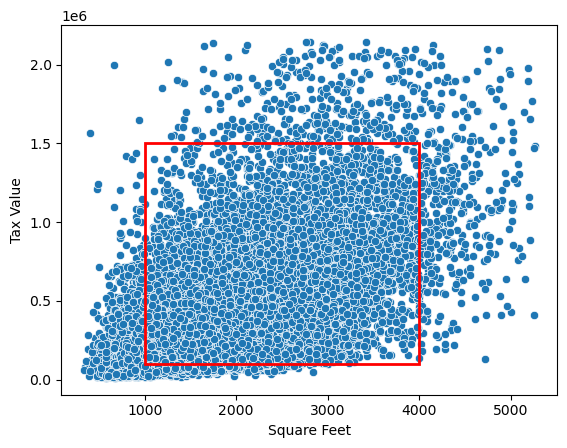

In [67]:
# Create figure and axes
fig, ax = plt.subplots()

sns.scatterplot(x='sq_ft', y='tax_value', data=train)

#add rectangle to plot
ax.add_patch(Rectangle((1000, 100000), 3000, 1400000,
                      edgecolor='red',
                      facecolor='none',
                      lw=2))
plt.xlabel('Square Feet')
plt.ylabel('Tax Value')

#display plot
plt.show()

## Lasso Lars

In [68]:
lars = LassoLars(alpha=1)

In [69]:
lars.fit(X_train, y_train)

LassoLars(alpha=1)

In [70]:
train_scaled['lars_preds'] = lars.predict(X_train)

In [71]:
train_scaled.head()

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0,baseline,lm_preds,lars_preds
11875,1.00,0.500,0.566443,1018390.0,0,1,0,396582.545956,675520.0,677787.172335
32390,0.50,0.250,0.250761,160053.0,1,0,0,396582.545956,350080.0,349353.345658
30688,0.75,0.625,0.660174,1154661.0,0,1,0,396582.545956,873536.0,873469.977686
5490,0.50,0.250,0.266180,286484.0,1,0,0,396582.545956,368512.0,367742.270088
27946,0.75,0.000,0.219111,197285.0,1,0,0,396582.545956,202560.0,204604.046245


In [72]:
e.better_than_baseline(y_train, train_scaled.lars_preds)


        Regression Errors
        -----------------
        SSE: 1937776774572506.5
        MSE: 64437908172.802155
        RMSE: 253846.22938464567
        ESS: 1012619251636615.0
        TSS: 2950396026209121.5
    

        Baseline Mean Errors
        -----------------
        SSE: 2953333808828537.0
        MSE: 98208759272.0317
        RMSE: 313382.76798833674
Results
------------------------------
 RMSE Preds: 253846.23
 RMSE Baseline: 313382.77
 Difference: 59536.54
MODEL IS BETTER!


(1937776774572506.5,
 64437908172.802155,
 253846.22938464567,
 1012619251636615.0,
 2950396026209121.5,
 2953333808828537.0,
 98208759272.0317,
 313382.76798833674)

In [73]:
val['lars_preds'] = lars.predict(X_val)

In [74]:
e.better_than_baseline(y_val, val.lars_preds)


        Regression Errors
        -----------------
        SSE: 784489545061650.4
        MSE: 60865043452.68449
        RMSE: 246708.41787965907
        ESS: 431040865435125.0
        TSS: 1215530410496775.5
    

        Baseline Mean Errors
        -----------------
        SSE: 1209690953675475.2
        MSE: 93854523522.03238
        RMSE: 306356.85649587214
Results
------------------------------
 RMSE Preds: 246708.42
 RMSE Baseline: 306356.86
 Difference: 59648.44
MODEL IS BETTER!


(784489545061650.4,
 60865043452.68449,
 246708.41787965907,
 431040865435125.0,
 1215530410496775.5,
 1209690953675475.2,
 93854523522.03238,
 306356.85649587214)

In [75]:
test['lars_preds'] = lars.predict(X_test)

In [76]:
lars_test = e.better_than_baseline(y_test, test.lars_preds)
lars_test


        Regression Errors
        -----------------
        SSE: 683373394960752.9
        MSE: 63622883806.04719
        RMSE: 252235.77027465234
        ESS: 366086658784051.7
        TSS: 1049460053744804.5
    

        Baseline Mean Errors
        -----------------
        SSE: 1032918693578739.5
        MSE: 96165970913.20543
        RMSE: 310106.3864437581
Results
------------------------------
 RMSE Preds: 252235.77
 RMSE Baseline: 310106.39
 Difference: 57870.62
MODEL IS BETTER!


(683373394960752.9,
 63622883806.04719,
 252235.77027465234,
 366086658784051.7,
 1049460053744804.5,
 1032918693578739.5,
 96165970913.20543,
 310106.3864437581)

## Tweedie Generalized Linear Model

In [77]:
glm = TweedieRegressor(power=0, alpha =7.5)

In [78]:
glm.fit(X_train, y_train)

TweedieRegressor(alpha=7.5, power=0)

In [79]:
train_scaled['glm_preds'] = glm.predict(X_train)

In [80]:
train_scaled.head()

,bedrooms,bathrooms,sq_ft,tax_value,fips_6037.0,fips_6059.0,fips_6111.0,baseline,lm_preds,lars_preds,glm_preds
11875,1.00,0.500,0.566443,1018390.0,0,1,0,396582.545956,675520.0,677787.172335,402323.300739
32390,0.50,0.250,0.250761,160053.0,1,0,0,396582.545956,350080.0,349353.345658,394895.277207
30688,0.75,0.625,0.660174,1154661.0,0,1,0,396582.545956,873536.0,873469.977686,402632.925998
5490,0.50,0.250,0.266180,286484.0,1,0,0,396582.545956,368512.0,367742.270088,394948.927022
27946,0.75,0.000,0.219111,197285.0,1,0,0,396582.545956,202560.0,204604.046245,394282.036537


In [81]:
e.better_than_baseline(y_train, train_scaled.glm_preds)


        Regression Errors
        -----------------
        SSE: 2933774902924200.0
        MSE: 97558356708.0407
        RMSE: 312343.3314608152
        ESS: 212952470787.68317
        TSS: 2933987855394987.5
    

        Baseline Mean Errors
        -----------------
        SSE: 2953333808828537.0
        MSE: 98208759272.0317
        RMSE: 313382.76798833674
Results
------------------------------
 RMSE Preds: 312343.33
 RMSE Baseline: 313382.77
 Difference: 1039.44
MODEL IS BETTER!


(2933774902924200.0,
 97558356708.0407,
 312343.3314608152,
 212952470787.68317,
 2933987855394987.5,
 2953333808828537.0,
 98208759272.0317,
 313382.76798833674)

## Polynomial Regression

In [82]:
pf = PolynomialFeatures(degree=3)

In [83]:
pf.fit(X_train, y_train)

PolynomialFeatures(degree=3)

In [84]:
X_train_d2 = pf.transform(X_train)

In [85]:
lm2 = LinearRegression(normalize=True)

In [86]:
lm2.fit(X_train_d2, y_train)

LinearRegression(normalize=True)

In [87]:
train_scaled['pf_preds'] = lm2.predict(X_train_d2)

In [88]:
e.better_than_baseline(y_train, train_scaled.pf_preds)


        Regression Errors
        -----------------
        SSE: 1900357456590964.0
        MSE: 63193583951.548416
        RMSE: 251383.34064044183
        ESS: 1039380271998859.4
        TSS: 2939737728589823.5
    

        Baseline Mean Errors
        -----------------
        SSE: 2953333808828537.0
        MSE: 98208759272.0317
        RMSE: 313382.76798833674
Results
------------------------------
 RMSE Preds: 251383.34
 RMSE Baseline: 313382.77
 Difference: 61999.43
MODEL IS BETTER!


(1900357456590964.0,
 63193583951.548416,
 251383.34064044183,
 1039380271998859.4,
 2939737728589823.5,
 2953333808828537.0,
 98208759272.0317,
 313382.76798833674)

In [89]:
X_val_d2 = pf.transform(X_val)

In [90]:
#lm2 = LinearRegression(normalize=True)

In [91]:
#lm2.fit(X_val_d2, y_val)

In [92]:
val['pf_preds'] = lm2.predict(X_val_d2)

In [93]:
e.better_than_baseline(y_val, val.pf_preds)


        Regression Errors
        -----------------
        SSE: 772547154781704.0
        MSE: 59938486677.14361
        RMSE: 244823.37853469714
        ESS: 442322272897492.94
        TSS: 1214869427679197.0
    

        Baseline Mean Errors
        -----------------
        SSE: 1209690953675475.2
        MSE: 93854523522.03238
        RMSE: 306356.85649587214
Results
------------------------------
 RMSE Preds: 244823.38
 RMSE Baseline: 306356.86
 Difference: 61533.48
MODEL IS BETTER!


(772547154781704.0,
 59938486677.14361,
 244823.37853469714,
 442322272897492.94,
 1214869427679197.0,
 1209690953675475.2,
 93854523522.03238,
 306356.85649587214)

In [94]:
X_test_d2 = pf.fit_transform(X_test)

In [95]:
lm2 = LinearRegression(normalize=True)

In [96]:
lm2.fit(X_train_d2, y_train)

LinearRegression(normalize=True)

In [97]:
test['pf_preds'] = lm2.predict(X_test_d2)

In [98]:
pr_test = e.better_than_baseline(y_test, test.pf_preds)
pr_test


        Regression Errors
        -----------------
        SSE: 675026275985800.0
        MSE: 62845757004.543335
        RMSE: 250690.56026213538
        ESS: 374295483337545.4
        TSS: 1049321759323345.4
    

        Baseline Mean Errors
        -----------------
        SSE: 1032918693578739.5
        MSE: 96165970913.20543
        RMSE: 310106.3864437581
Results
------------------------------
 RMSE Preds: 250690.56
 RMSE Baseline: 310106.39
 Difference: 59415.83
MODEL IS BETTER!


(675026275985800.0,
 62845757004.543335,
 250690.56026213538,
 374295483337545.4,
 1049321759323345.4,
 1032918693578739.5,
 96165970913.20543,
 310106.3864437581)